# sanity check GISready `netcdf`

Date: 11 June, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is on the order of 50TB of float data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from dask.distributed import Client, LocalCluster
import dask
import datetime
import zarr

import gc
import sys
import subprocess
from tabulate import tabulate
import os
import glob
import streamjoy
import pickle
import json

In [2]:
# Append the directory of the module to sys.path - import functions
sys.path.append('/g/data/es60/users/thomas_moore/code/Climatology-generator-demo/src/')
import bran2020_demo_functions as my_tools
from bran2020_demo_functions import keep_only_selected_vars, load_rechunker_config, print_chunks, rechunk_each_st_ocean, remove_zarr_encoding, version_table, concatinate_st_ocean_zarrs

#### start a local Dask client

In [3]:
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

cluster = LocalCluster(
    n_workers=28,          # Number of workers
    threads_per_worker=1#,
    #memory_limit='8GB' # Memory limit per each worker
)
client = Client(cluster)

# functions

In [4]:
GISready_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/'
final_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_final_results/'
intermediate_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_intermediate_results/'

In [5]:
def load_GISready_ds(GISready_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/',
                     core_var='temp',phase='la_nina'):
    ds = xr.open_mfdataset(GISready_results_path+phase+'/'+core_var+'/*.nc',concat_dim='month',combine='nested',parallel=True)
    return ds

In [18]:
GIS_temp_ds = xr.merge([load_GISready_ds(phase='alltime'),load_GISready_ds(phase='el_nino'),load_GISready_ds(phase='la_nina'),load_GISready_ds(phase='neutral')])
GIS_u_ds = xr.merge([load_GISready_ds(phase='alltime',core_var='u'),load_GISready_ds(phase='el_nino',core_var='u'),
                     load_GISready_ds(phase='la_nina',core_var='u'),load_GISready_ds(phase='neutral',core_var='u')])
GIS_mld_ds = xr.merge([load_GISready_ds(phase='alltime',core_var='mld'),load_GISready_ds(phase='el_nino',core_var='mld'),
                     load_GISready_ds(phase='la_nina',core_var='mld'),load_GISready_ds(phase='neutral',core_var='mld')])

## "final"

In [11]:
final_temp_ds = xr.open_mfdataset(final_results_path+'*temp*.nc',parallel=True)
final_u_ds = xr.open_mfdataset(final_results_path+'*_u_*.nc',parallel=True)
final_mld_ds = xr.open_mfdataset(final_results_path+'*mld*.nc',parallel=True)
final_eta_t_ds = xr.open_mfdataset(final_results_path+'*_eta_t_*.nc',parallel=True)

## intermediate

In [8]:
# Create an empty dictionary
dynamic_ds = {}

# Define your var and phase lists
var_values = ['temp', 'salt','u','v','eta_t','mld']  # 
phase_values = ['alltime', 'neutral','la_nina','el_nino']  # 


# Iterate over all combinations of var and phase
for var_name in var_values:
    for phase_name in phase_values:
        # Generate the object name
        ds_name = f'{var_name}_{phase_name}_ds'
        
        # Store the value in the dictionary
        results_path = intermediate_results_path
        files = glob.glob(results_path+'*_'+var_name+'_*'+phase_name+'*.nc')
        sorted_files = sorted(files, key=os.path.getctime)
        #print('>>>>> '+var_name+'&'+phase_name+' <<<<<')
        #print(sorted_files)
        
        dynamic_ds[ds_name] = xr.open_mfdataset(files,parallel=True)  # replace with your actual value


In [9]:
# Add the phase string to the name of all variables in each dataset
for ds_name, dataset in dynamic_ds.items():
    # Get the phase name from the dataset name
    phase_name = '_'.join(ds_name.split('_')[1:-1])
    if phase_name not in phase_values:
        phase_name = '_'.join(ds_name.split('_')[2:-1])
    if phase_name in phase_values:
        # Add the phase string to the name of all variables
        for var_name in dataset.data_vars:
            new_var_name = f'{var_name}_{phase_name}'
            dataset = dataset.rename({var_name: new_var_name})
        dynamic_ds[ds_name] = dataset
    else:
        print(f"No match found for phase name: {phase_name}")

In [10]:
merged_datasets = {}
for var_name in var_values:
        # Get all datasets with the same var_name
        var_datasets = [dataset for ds_name, dataset in dynamic_ds.items() if var_name+'_' in ds_name]
        
        # Merge the datasets along the time dimension
        merged_dataset = xr.merge(var_datasets)
        
        # Store the merged dataset in the dictionary
        merged_datasets[var_name] = merged_dataset
intermediate_datasets = merged_datasets

# Does "final" = "intermediate"

In [15]:
%%time
xr.testing.assert_equal(final_mld_ds,intermediate_datasets['mld'])

CPU times: user 2min 55s, sys: 13.2 s, total: 3min 8s
Wall time: 4min 17s


In [16]:
%%time
xr.testing.assert_equal(final_eta_t_ds,intermediate_datasets['eta_t'])

CPU times: user 2min 50s, sys: 12.2 s, total: 3min 2s
Wall time: 4min 5s


In [17]:
%%time
xr.testing.assert_equal(final_u_ds.mean_u_alltime,intermediate_datasets['u'].mean_u_alltime)

/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 14.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 47s, sys: 8.49 s, total: 2min 55s
Wall time: 2min 58s


# Does "GISready" equal "final"

In [ ]:
%%time
xr.testing.assert_equal(final_u_ds.mean_u_alltime,GIS_u_ds.mean_u_alltime)

/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 31.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
%%time
xr.testing.assert_equal(final_mld_ds,GIS_mld_ds)

In [5]:
def print_file_structure(root_path):
    for root, dirs, files in os.walk(root_path):
        level = root.replace(root_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for file in files:
            print(f"{sub_indent}{file}")

print_file_structure(results_path)

/
logs/
    GISready_export_log.txt
el_nino/
    salt/
        BRAN2020_salt_mth_07.nc
        BRAN2020_salt_mth_06.nc
        BRAN2020_salt_mth_03.nc
        BRAN2020_salt_mth_09.nc
        BRAN2020_salt_mth_05.nc
        BRAN2020_salt_mth_11.nc
        BRAN2020_salt_mth_04.nc
        BRAN2020_salt_mth_01.nc
        BRAN2020_salt_mth_12.nc
        BRAN2020_salt_mth_10.nc
        BRAN2020_salt_mth_08.nc
        BRAN2020_salt_mth_02.nc
    u/
        BRAN2020_u_mth_08.nc
        BRAN2020_u_mth_12.nc
        BRAN2020_u_mth_11.nc
        BRAN2020_u_mth_01.nc
        BRAN2020_u_mth_07.nc
        BRAN2020_u_mth_02.nc
        BRAN2020_u_mth_10.nc
        BRAN2020_u_mth_05.nc
        BRAN2020_u_mth_03.nc
        BRAN2020_u_mth_04.nc
        BRAN2020_u_mth_09.nc
        BRAN2020_u_mth_06.nc
    eta_t/
        BRAN2020_eta_t_mth_03.nc
        BRAN2020_eta_t_mth_08.nc
        BRAN2020_eta_t_mth_10.nc
        BRAN2020_eta_t_mth_11.nc
        BRAN2020_eta_t_mth_07.nc
        BRAN2020_eta_t_mth_06.

In [6]:
# Make path objects for each lowest level of the file structure
folder_paths = []
for root, dirs, files in os.walk(results_path):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        folder_paths.append(folder_path)
folder_paths

['/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/logs',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/el_nino',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/neutral',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/alltime',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/la_nina',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/el_nino/salt',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/el_nino/u',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/el_nino/eta_t',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/el_nino/mld',
 '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/el_nino/temp',
 '/g/data/es60/users/thomas_moore/clim_de

In [7]:
temp_neutral = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/neutral/temp/*.nc',concat_dim='month',combine='nested',parallel=True)
temp_neutral

<xarray.Dataset> Size: 93GB
Dimensions:                   (xt_ocean: 3600, yt_ocean: 1500, st_ocean: 51,
                               month: 12)
Coordinates:
  * xt_ocean                  (xt_ocean) float64 29kB 0.05 0.15 ... 359.9 360.0
  * yt_ocean                  (yt_ocean) float64 12kB -74.95 -74.85 ... 74.95
  * st_ocean                  (st_ocean) float64 408B 2.5 7.5 ... 4.509e+03
  * month                     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mean_temp_neutral         (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    std_temp_neutral          (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    min_temp_neutral          (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    max_temp_neutral          (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    median_temp_neutral       (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    quantile_05_temp_neutral  (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    quantile_95_temp_neutral  (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    packing:        4
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-32767  32767]

In [8]:
temp_la_nina = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/la_nina/temp/*.nc',concat_dim='month',combine='nested',parallel=True)
temp_la_nina

<xarray.Dataset> Size: 93GB
Dimensions:                   (xt_ocean: 3600, yt_ocean: 1500, st_ocean: 51,
                               month: 12)
Coordinates:
  * xt_ocean                  (xt_ocean) float64 29kB 0.05 0.15 ... 359.9 360.0
  * yt_ocean                  (yt_ocean) float64 12kB -74.95 -74.85 ... 74.95
  * st_ocean                  (st_ocean) float64 408B 2.5 7.5 ... 4.509e+03
  * month                     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mean_temp_la_nina         (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    std_temp_la_nina          (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    min_temp_la_nina          (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    max_temp_la_nina          (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    median_temp_la_nina       (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    quantile_05_temp_la_nina  (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
    quantile_95_temp_la_nina  (month, st_ocean, yt_ocean, xt_ocean) float32 13GB dask.array<chunksize=(1, 11, 300, 720), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    packing:        4
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-32767  32767]

In [9]:
ds1 = temp_la_nina
ds2 = temp_neutral

In [7]:
def load_GISready_ds(core_var='temp',phase='la_nina'):
    ds = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/'+phase+'/'+core_var+'/*.nc',concat_dim='month',combine='nested',parallel=True)
    return ds

In [8]:
ds1 = load_GISready_ds(core_var='salt',phase='la_nina')
ds2 = load_GISready_ds(core_var='salt',phase='neutral')

In [ ]:
# Function to count NaNs in a dataset
def count_nans(ds):
    nan_counts = {}
    for var in ds.data_vars:
        nan_counts[var] = ds[var].isnull().sum().compute().item()  # Use .compute() to handle dask arrays
    return nan_counts

In [ ]:
# Count total NaNs in both datasets
total_nans_ds1 = count_nans(ds1)
total_nans_ds2 = count_nans(ds2)

# Print the total NaN counts for each dataset
print(f"Total NaNs in ds1: {total_nans_ds1}")
print(f"Total NaNs in ds2: {total_nans_ds2}")

In [10]:
# Function to find variables matching the prefixes
def find_matching_vars(ds, prefixes):
    matching_vars = {}
    for prefix in prefixes:
        matching_vars[prefix] = [var for var in ds.data_vars if var.startswith(prefix)]
    return matching_vars

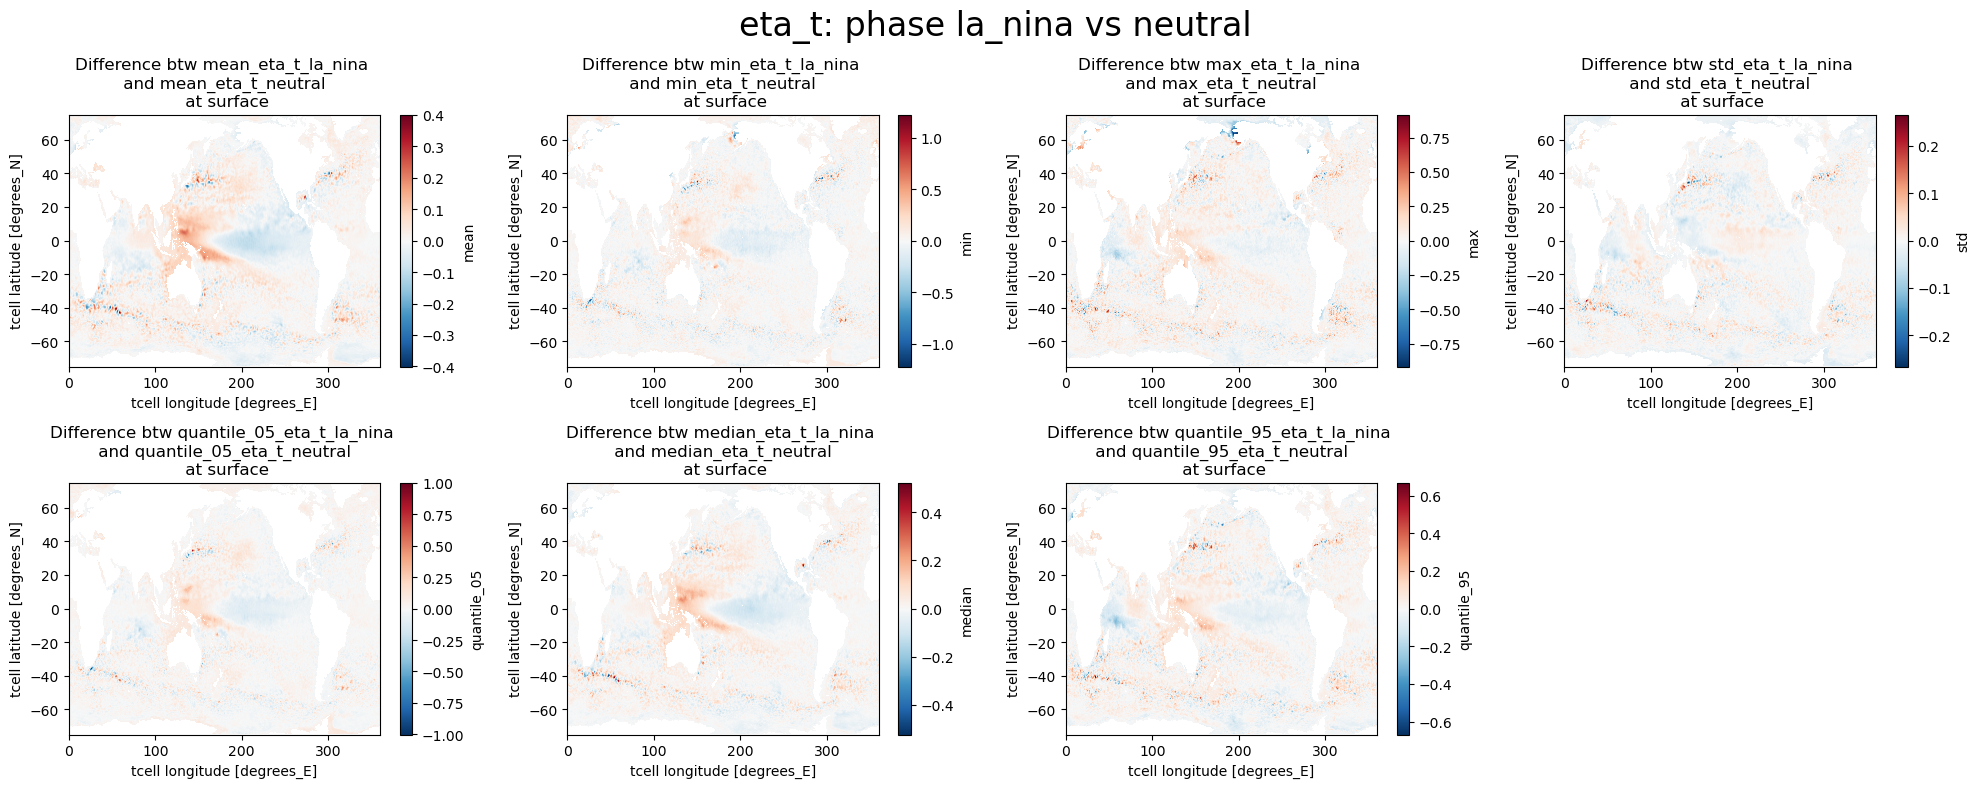

In [13]:
core_var = 'eta_t'
phase1 = 'la_nina'
phase2 = 'neutral'

ds1 = load_GISready_ds(core_var=core_var,phase=phase1)
ds2 = load_GISready_ds(core_var=core_var,phase=phase2)


# Define a list of prefixes
prefixes = ['mean','min','max','std','quantile_05','median','quantile_95']

matching_vars_ds1 = find_matching_vars(ds1,prefixes)
matching_vars_ds2 = find_matching_vars(ds2,prefixes)


# Calculate number of subplots needed
num_prefixes = len(prefixes)
num_cols = 4
num_rows = (num_prefixes + num_cols - 1) // num_cols  # Ceiling division

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()



for i, prefix in enumerate(prefixes):

    diff = ds1[matching_vars_ds1[prefix]].rename({matching_vars_ds1[prefix][0]:prefix}) - ds2[matching_vars_ds2[prefix]].rename({matching_vars_ds2[prefix][0]:prefix})
    if 'st_ocean' in diff.variables:
        diff = diff.isel({'st_ocean': 0, 'month': 0})
    else:
        diff = diff.isel({'month': 0})

    # Plot the difference
    diff[prefix].plot(ax=axes[i], cmap='RdBu_r')
    axes[i].set_title(f'Difference btw {matching_vars_ds1[prefix][0]} \n and {matching_vars_ds2[prefix][0]} \n at surface')
    i += 1

# Remove any empty subplots
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle(t = core_var+': phase '+ phase1 +' vs ' + phase2,fontsize=24, color='black')
plt.tight_layout()
plt.show()

## define phase and core variable names

In [14]:
phase_list=['alltime','la_nina','el_nino','neutral']
core_var_list=['temp','salt','u','v','mld','eta_t']

## Define a dictionary to map variable names to colors and styles

In [15]:
# Define a dictionary to map variable names to colors and styles
base_color_dict = {
    'mean': 'black',
    'min': 'navy',
    'max': 'red',
    'std': 'lightgrey',
    'median':'darkgrey',
    'quantile_05':'lightblue' ,
    'quantile_95': 'orange'
}
base_style_dict = {
    'alltime':'solid',
    'neutral':'dashdot',
    'la_nina':'dotted',
    'el_nino':'dashed'
}

In [19]:
ds1 = load_GISready_ds(core_var='temp',phase='la_nina')
ds2 = load_GISready_ds(core_var='temp',phase='el_nino')
ds = xr.merge([ds1,ds2])

In [20]:
color_dict={}
style_dict={}
variables = list(ds.data_vars)
for var_name in variables:
    # Get the first part of the variable name
    var_prefix = var_name.split('_')[0]
    
    # Check if the var_prefix exists in color_dict
    if var_prefix in base_color_dict:
        # Get the corresponding color from color_dict
        color_dict[var_name] = base_color_dict[var_prefix]
        
        # Use the color for further processing or visualization
        # . . .
        
    else:
        var_prefix = '_'.join(var_name.split('_')[:2])
        if var_prefix in base_color_dict:
            # Get the corresponding color from color_dict
            color_dict[var_name] = base_color_dict[var_prefix]
        
            # Use the color for further processing or visualization
            # ...
        else:
            print(f"No color defined for variable prefix: {var_prefix}")
for var_name in variables:
    # Get the first part of the variable name
    var_prefix = var_name.split('_')[-1]
    
    # Check if the var_prefix exists in color_dict
    if var_prefix in base_style_dict:
        # Get the corresponding color from color_dict
        style_dict[var_name] = base_style_dict[var_prefix]
        
        # Use the style for further processing or visualization
        # . . .
        
    else:
        var_prefix = '_'.join(var_name.split('_')[-2:])
        if var_prefix in base_style_dict:
            # Get the corresponding color from color_dict
            style_dict[var_name] = base_style_dict[var_prefix]
        
            # Use the style for further processing or visualization
            # ...
        else:
            print(f"No style defined for variable prefix: {var_prefix}")

In [21]:
coordinate_names = {"lat_name_dict": {
        "temp": "yt_ocean",
        "salt": "yt_ocean",
        "u": "yu_ocean",
        "v": "yu_ocean",
        "mld": "yt_ocean",
        "eta_t": "yt_ocean"
    },
    "lon_name_dict": {
        "temp": "xt_ocean",
        "salt": "xt_ocean",
        "u": "xu_ocean",
        "v": "xu_ocean",
        "mld": "xt_ocean",
        "eta_t": "xt_ocean"
    }
                   }

# equator @ surface

In [23]:
sel_dict = {'st_ocean': 0, 'yt_ocean': 0,'month':1}

In [26]:
depth_sel_dict = {'st_ocean':0}
lon_sel_dict = {coordinate_names["lat_name_dict"][core_var]:0}
month_sel_dict = {'month':3}
sel_dict = {**depth_sel_dict, **lon_sel_dict, **month_sel_dict}

In [27]:
eq = ds.sel(sel_dict,method='nearest').compute()

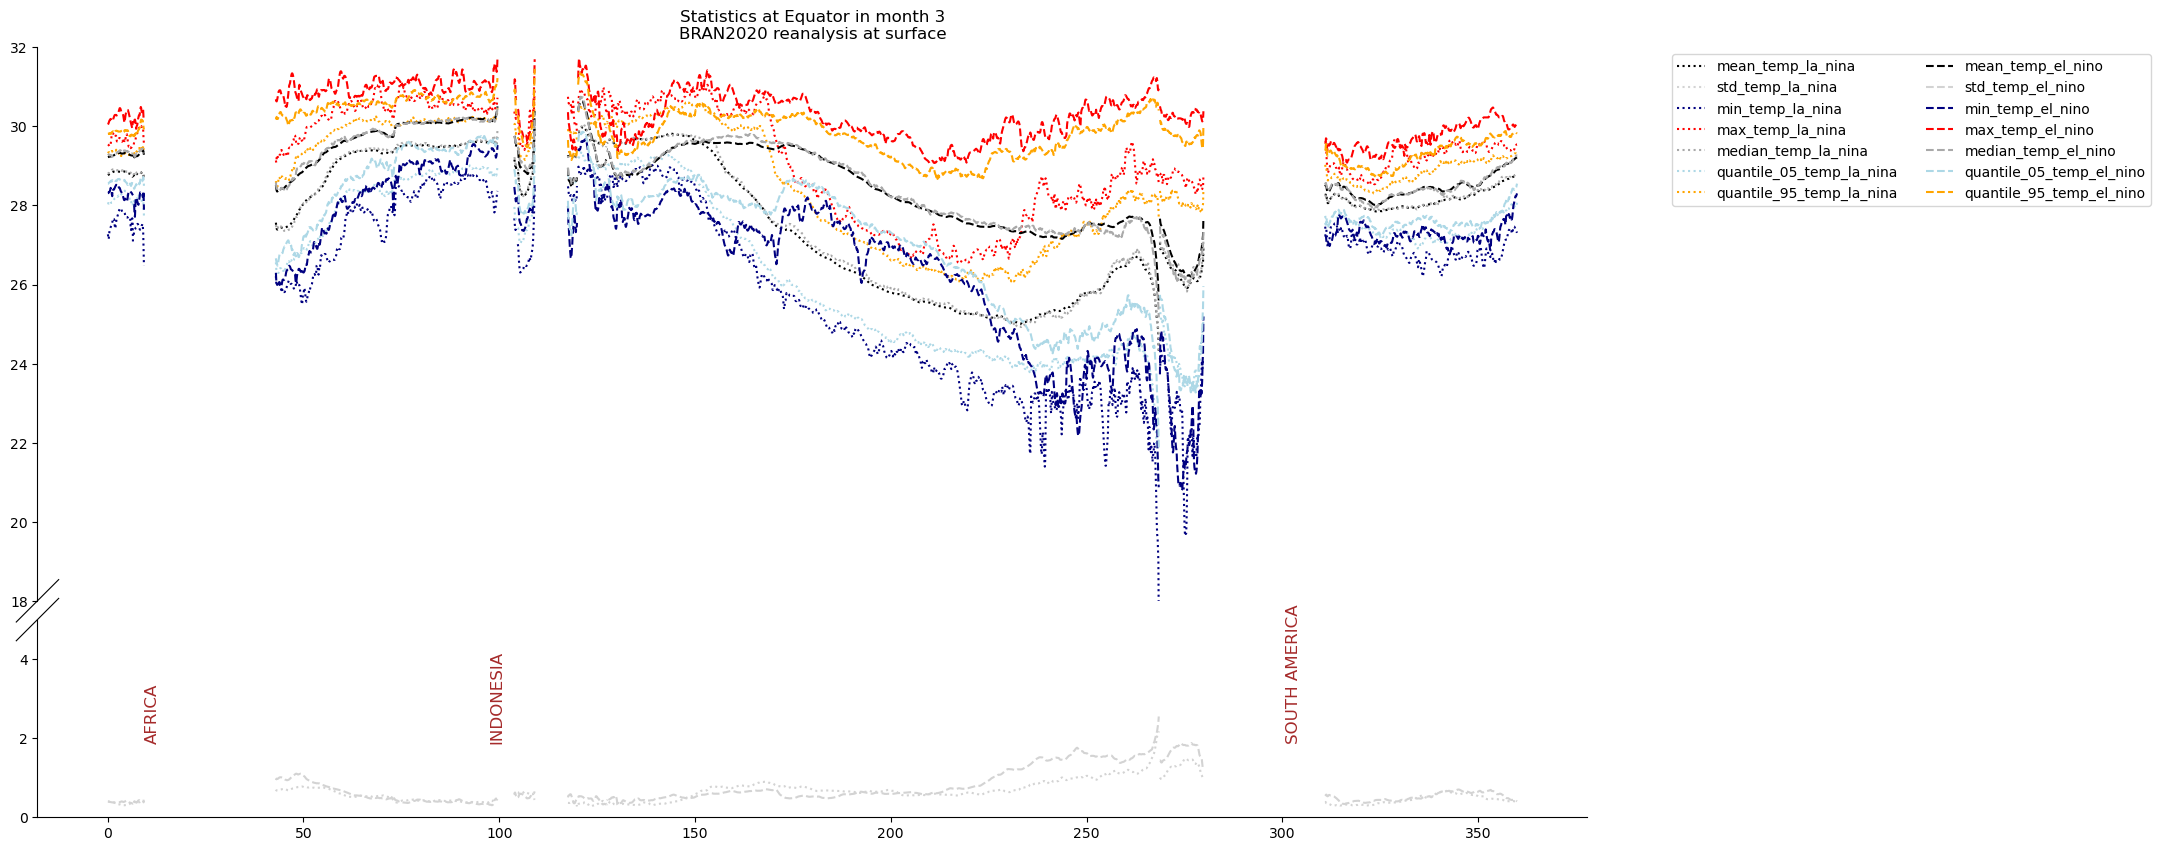

In [28]:
from brokenaxes import brokenaxes
#plot
# Get the list of variables in the dataset
variables = list(ds.data_vars)

# Plot line for each variable
fig = plt.figure(figsize=(20, 10))  # Set the figure size here
bax = brokenaxes(ylims=((0, 5), (18, 32)), hspace=.05)
for variable in variables:
    color = color_dict.get(variable, 'black')  # Use 'black' as default color if variable is not in the dictionary
    style = style_dict.get(variable, 'solid')
    #bax.plot(ds[variable].sel(sel_dict,method='nearest'),color=color, linestyle=style)
    bax.plot(eq[coordinate_names["lon_name_dict"][core_var]].values,eq[variable].values,color=color, linestyle=style, label=variable)
    # Add text to a specific location

y_location = 0.1    
bax.big_ax.text((25/360), y_location, 'AFRICA', fontsize=12, color='brown', rotation=90)
bax.big_ax.text((105/360), y_location, 'INDONESIA', fontsize=12, color='brown', rotation=90)
bax.big_ax.text((290/360), y_location, 'SOUTH AMERICA', fontsize=12, color='brown', rotation=90)
# Add title
plt.title('Statistics at Equator in month '+str(month_sel_dict['month'])+'\nBRAN2020 reanalysis at surface')
#legend
# Add legend with two columns
bax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.show()


In [ ]:
ds2[matching_vars_ds2[prefix]]

In [ ]:
def build_nc_path_list(root_directory = "/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/",search_string = "_temp_"):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            if file.endswith(".nc") and search_string in file:
                    file_paths.append(os.path.join(root, file))
    file_paths.sort()
    return file_paths

In [ ]:
def build_nc_path_list(root_directory="/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/", search_string="_temp_", search_string2="neutral"):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        if search_string2 in dirs:
            for file in files:
                if file.endswith(".nc") and search_string in file:
                    file_paths.append(os.path.join(root, file))
        file_paths.sort()
    return file_paths

In [ ]:
file_paths = build_nc_path_list(root_directory="/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/", search_string="_temp_", search_string2="neutral")
file_paths

In [ ]:
temp = xr.open_mfdataset(build_nc_path_list(),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
salt = xr.open_mfdataset(build_nc_path_list(search_string = "_salt_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
u = xr.open_mfdataset(build_nc_path_list(search_string = "_u_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
v = xr.open_mfdataset(build_nc_path_list(search_string = "_v_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
mld = xr.open_mfdataset(build_nc_path_list(search_string = "_mld_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
eta_t = xr.open_mfdataset(build_nc_path_list(search_string = "_eta_t_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()

In [ ]:
check_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_final_results/'

In [ ]:
temp2 = xr.open_mfdataset(check_path+'*temp*.nc',chunks={})

In [ ]:
temp2 - temp

In [ ]:
# Calculate the difference for each variable
ds_diff = temp2 - temp

# Plotting
variables = ds_diff.data_vars.keys()
num_vars = len(variables)

# Create subplots
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))  # Adjust the layout as needed
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    ds_diff[var].isel(month=0, st_ocean=0).plot(ax=ax)  # Adjust the slicing as needed
    ax.set_title(var)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
temp = xr.open_mfdataset(folder_paths[8]+'/*.nc',parallel=True,concat_dim='month', combine='nested')

In [ ]:
temp.mean_temp_el_nino.isel(st_ocean=0).sel(yt_ocean = -20,method='nearest').mean('xt_ocean').plot()

## coordinate nomeclature

In [ ]:
coordinate_names = {
    "lat_name_dict": {
        "temp": "yt_ocean",
        "salt": "yt_ocean",
        "u": "yu_ocean",
        "v": "yu_ocean",
        "mld": "yt_ocean",
        "eta_t": "yt_ocean"
    },
    "lon_name_dict": {
        "temp": "xt_ocean",
        "salt": "xt_ocean",
        "u": "xu_ocean",
        "v": "xu_ocean",
        "mld": "xt_ocean",
        "eta_t": "xt_ocean"
    },
    "depth_name_dict": {
        "temp": "st_ocean",
        "salt": "st_ocean",
        "u": "st_ocean",
        "v": "st_ocean"
    }
}

# $The$ $End$

In [ ]:
client.shutdown()